In [31]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from plot_settings import define_plot_settings

project_dir = os.path.abspath('..')
print(f"Project directory: {project_dir}")
sys.path.append(os.path.join(project_dir))

Project directory: /work3/mtaho/PhD/DeepLearning/DeepLearning_PAINN


### Benchmark results (from PaiNN paper)

Here, the benchmark results from the PaiNN paper are restated:

In [32]:
test_mae_benchmark = np.array([[0.012, 0.045, 27.6, 20.4, 45.7, 0.066, 1.28, 5.85, 5.83, 5.98, 7.35, 0.024]])
target_names = ['mu', 'alpha', 'eps_HOMO', 'eps_LUMO', 'deps', 'R2', 'ZPVE', 'U0', 'U', 'H', 'G','cv']
df_benchmark = pd.DataFrame(data=test_mae_benchmark, columns=target_names)
df_benchmark.index=['Reference']

## Training history

Load training history data

In [33]:
def load_all_results(parameter, values, relative_path):
    data = {}
    res_all = {}
    results_path = f"{project_dir}/{relative_path}"
    
    for val in values:
        for dirpath, dirnames, filenames in os.walk(results_path):
                
            if (f"{parameter}_{val}") in dirpath: 

                for file in sorted(filenames):

                    if ".pickle" in file:

                        with open(f"{dirpath}/{file}", 'rb') as pf:
                            p = pickle.load(pf)
                            res = p

                        res[parameter] = val

                        res_all[f"{parameter}_{val}"] = res
    return res_all    

relative_path = 'runs/train/2024-12-06'
target=7
parameter = 'tMax'
values = [200, 400, 600, 800, 1000]
# parameter = 'target'
# values = [6, 7, 8, 9]
res_all = load_all_results(parameter, values, relative_path)

print(res_all.keys())
res_all['tMax_200'].keys()

dict_keys(['tMax_200', 'tMax_400', 'tMax_600', 'tMax_800', 'tMax_1000'])


dict_keys(['train_loss', 'val_loss', 'train_MAE', 'val_MAE', 'lr', 'epoch', 'test_MAE', 'val_loss_smoothed', 'tMax'])

Print table to compare with benchmark

In [34]:
test_MAEs = [res_all[res]['test_MAE'][0] for res in res_all]

# targets = [target_names[res_all[res]['target']] for res in res_all]
tMaxs = [res_all[res]['tMax'] for res in res_all]
new_row = dict(zip(tMaxs, test_MAEs))

# Add to dataframe
# df = pd.concat([df, pd.DataFrame([new_row])])
# relative_errors = (df.iloc[1] - df.iloc[0])/df.iloc[0]
# df = pd.concat([df, pd.DataFrame([relative_errors])])
# df = pd.DataFrame(df)
# df.index = ['Reference', 'Predicted', 'Relative Error']

test_MAEs_reference = np.tile(df_benchmark[target_names[target]].values, len(values))
data = np.vstack([test_MAEs, test_MAEs_reference])
df = pd.DataFrame(data=data,  columns=values)
relative_errors = (df.iloc[0] - df.iloc[1])/df.iloc[1]
df = pd.concat([df, pd.DataFrame([relative_errors])])
df = pd.DataFrame(df)

In [35]:
df.fillna('-', inplace=False)

,200,400,600,800,1000
0,11.244804,8.545981,7.703357,7.450448,7.366550
1,5.850000,5.850000,5.850000,5.850000,5.850000
0,0.922189,0.460852,0.316813,0.273581,0.259239


Plot training progress and results

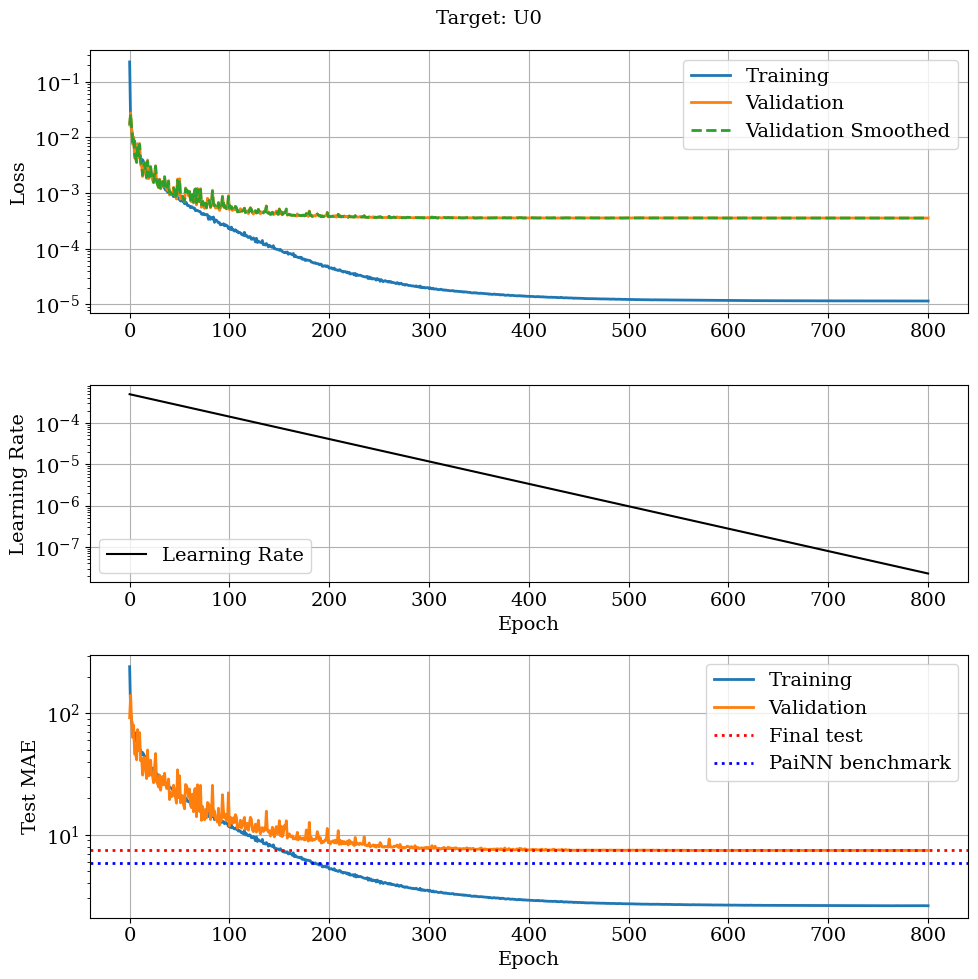

Reference = 5.85
Predicted = 7.45
Relative error = -27.358086%


In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), height_ratios=[1, 0.75, 1])

define_plot_settings(14)

def plot_training_progress(data, target_name):
    lw = 2.0
    # Plot primary y-axis (losses) on the first subplot
    ax1.semilogy(data['epoch'], data['train_loss'],'-', lw=lw, label='Training')
    ax1.semilogy(data['epoch'], data['val_loss'],'-', lw=lw, label='Validation')
    try:
        ax1.semilogy(data['epoch'], data['val_loss_smoothed'],'--', lw=lw, label='Validation Smoothed')
    except:
        pass
    # ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')  # Legend for the first y-axis
    ax1.grid(True)

    # Plot secondary y-axis (learning rate) on the second subplot
    ax2.semilogy(data['epoch'], data['lr'], 'k-', label='Learning Rate')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate', color='k')
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.legend(loc='lower left')  # Combine legends
    ax2.grid(True)

    # target_name = target_names[data['target']]
    plt.suptitle(f"Target: {target_name}")
    fig.tight_layout()

    reference_value = df_benchmark[target_name].values[0]

    # Plot primary y-axis (losses) on the first subplot
    ax3.semilogy(data['epoch'], data['train_MAE'],'-', lw=lw, label='Training')
    ax3.semilogy(data['epoch'], data['val_MAE'],'-', lw=lw, label='Validation')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Test MAE')
        # Plot test MAE as a horizontal line
    test_mae = data['test_MAE'][0]  # Convert tensor to a scalar
    ax3.axhline(y=test_mae, color='r', linestyle=':', lw=lw, label='Final test')
    ax3.axhline(y=reference_value, color='b', linestyle=':', lw=lw, label='PaiNN benchmark')
    ax3.legend(loc='upper right')  # Update legend to include Test MAE
    ax3.grid(True)
    fig.tight_layout()
    plt.show()

    rel_err = (reference_value - test_mae)/reference_value
    print(f"Reference = {reference_value:1.2f}")
    print(f"Predicted = {test_mae:1.2f}")
    print(f"Relative error = {rel_err:%}")


# print(f"{target=}")
plot_training_progress(res_all['tMax_800'], target_names[target])

## Trained model 

Load trained model

In [37]:
from src.models import model_loader
results_path = f"{project_dir}/{relative_path}"
checkpoint_path = f"{results_path}/model_checkpoint.pth"

painn, metadata = model_loader.load_checkpoint(checkpoint_path);

print(painn)
 

/work3/mtaho/PhD/DeepLearning/DeepLearning_PAINN/src/models/model_loader.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


FileNotFoundError: [Errno 2] No such file or directory: '/work3/mtaho/PhD/DeepLearning/DeepLearning_PAINN/runs/train/2024-12-06/model_checkpoint.pth'

In [ ]:
res_all['target_7'].keys()


dict_keys(['train_loss', 'val_loss', 'train_MAE', 'val_MAE', 'lr', 'epoch', 'test_MAE', 'val_loss_smoothed', 'target'])

Plot cosine annealing LR

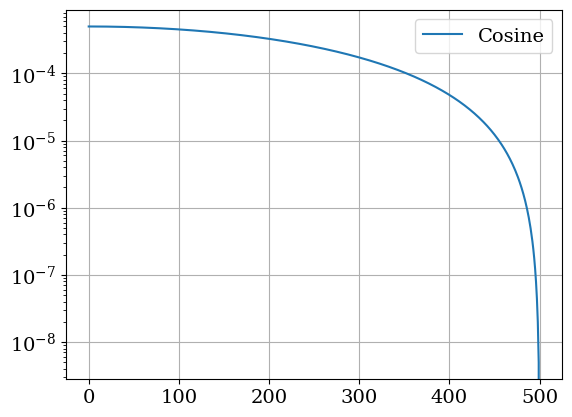

In [ ]:
eta_min = 0.0
T_max = 500
T_cur = np.linspace(0, T_max, 500)
eta_max = 5e-4
eta_t = eta_min + 0.5*(eta_max - eta_min)*(1 + np.cos(T_cur/T_max*np.pi))

plt.semilogy(T_cur, eta_t, label='Cosine')
plt.legend()
plt.grid()

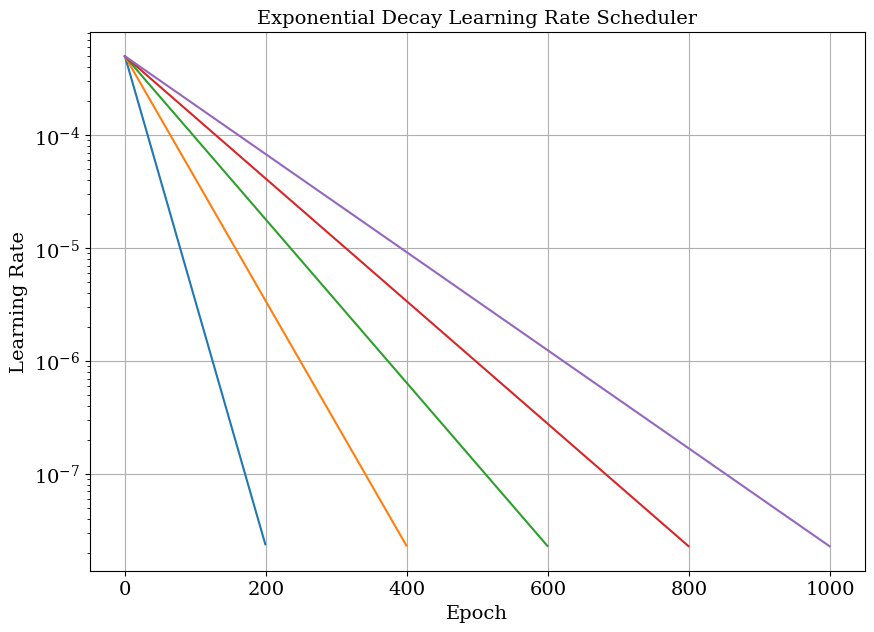

In [ ]:
import torch 

# Parameters
initial_lr = 5.0e-4
max_epochs = [200, 400, 600, 800, 1000]


fig, ax = plt.subplots(figsize=(10, 7))

for tMax in max_epochs:
    decay_rate = 10/tMax

    # Torch model
    model = torch.nn.Linear(2, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=np.exp(-decay_rate))
    lrs = []

    # # Generate learning rate schedule
    # lr = [
    # initial_lr * np.exp(-decay_rate * epoch) 
    # for epoch in range(tMax)
    # ]

    for i in range(tMax):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    # Plot
    # ax.semilogy(lr)
    ax.semilogy(lrs, '-')
    ax.set_title('Exponential Decay Learning Rate Scheduler')
    ax.set_ylabel('Learning Rate')
    ax.set_xlabel('Epoch')
    ax.grid()

NameError: name 'initial_lr' is not defined